In [1]:
import numpy as np
import pandas as pd
import glob
import re
import os
import seaborn as sns
from itertools import groupby


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import pandas as pd
import tensorflow as tf

from tensorflow.keras import datasets, layers, models, Model
import matplotlib.pyplot as plt

from math import *
from tensorflow import keras

from tensorflow import keras
from keras.models import Model, load_model
from keras.utils.vis_utils import plot_model
#from keras.optimizers import Adam, SGD
from keras.layers import *
from keras.metrics import *
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
#from hyperopt import hp, STATUS_OK

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D, \
                                    GlobalAveragePooling1D, AveragePooling1D
from keras.preprocessing import sequence
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import LeakyReLU
## sequence.pad_sequence(train_x, maxlen=max_words)
import pickle
import matplotlib.pyplot as plt

from scipy.stats import sem
from numpy import mean
from numpy import std
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics

# Define Path to MIEC Data

In [2]:
path1 = '/stg3/data1/chad/MIEC_data/'
path3 = '/stg3/data1/chad/MIEC_data/generalizePairDist_15A_noH_10A.list'

file2 = 'MIEC_10A_T_Full_AVER.list'

# Function for MIEC DataFrame 

In [3]:

########### Preprocessing ##############

def df1(path, file):
    df = pd.read_csv(path1+file2, delimiter= ' ', header= None)
    df.iloc[0,2:]
    return df


#df1(path1,file2)
######################

######################

def four_inter(data):
    df = []
#    print(data)
    df = data
    c_ln = int(df.shape[1])
    n_dim = c_ln/4
    
    lt = ["VDW", "ELE", "GB", "SA"]
    op = []
    
    for k, j in enumerate(lt):
        if lt[k] == j:
            for i in range(int(n_dim)):
                f = j + "_" + str(i)
                op.append(f)
            
            
    res = [list(i) for j, i in groupby(op, lambda a: a.split('_')[0])]
    df1 = pd.DataFrame(res[0])
    df2 = pd.DataFrame(res[1])
    df3 = pd.DataFrame(res[2])
    df4 = pd.DataFrame(res[3])
    
    column_names = pd.concat([df1,df2,df3,df4], axis=1).to_numpy().flatten().tolist()
    nam = ["names"]
    bind = ["bind"]

    lt_col = nam + bind + column_names
    
    return lt_col

def df_intCol():
    df = pd.read_csv(path1+file2, delimiter=' ',names=four_inter(df1(path1,file2)))
    return df
    
def bind():
    df = df_intCol()
    df_bind = df['bind']
    return df_bind

def ary_bind():
    df_bind = bind()
    ary_bindd = np.asarray(df_bind)
    return ary_bindd
    

def df_SclWmax():
    df = df_intCol()
    df_max = pd.DataFrame({'max': abs(df.iloc[:,2:]).max(axis=1)})
    df2 = pd.concat([df, df_max], axis = 1)
    df2_drop=df2.drop(columns=['names','bind','max'])
    max_values = df2['max']
    df2_div = df2_drop.divide(max_values, axis=0)
    df2_scaled = pd.concat([df2[['names','bind']],df2_div], axis = 1)
    return df2_scaled

def df2_ary():
    df2_scaled = df_SclWmax()
    df2_ary = np.asarray(df2_scaled.iloc[:,2:])
    return df2_ary

def data_vec():
    num_rows = df_SclWmax().shape[0]
    ary1 = []
    for i in range(num_rows):
        ary1.append(df2_scaled.iloc[:,2:].iloc[i].to_numpy().tolist())
    return ary1

def n_x_4():
    ary1 = data_vec()
    ary2 = []
    for k in range(len(ary1)):
        hj = [ary1[k][i:i + 4] for i in range(0, len(ary1[k]), 4)]
        ary2.append(hj)
    ary3 = np.array(ary2)
    return ary3

############## Training & Test Data ###############

def train_test1():
    training_data, testing_data = train_test_split(n_x_4(), test_size=0.1, random_state=10)
    x_train3, x_test3, y_train3, y_test3 = train_test_split(n_x_4(), ary_bind(), test_size=0.1, random_state=10)
    
    return x_train3, x_test3, y_train3, y_test3

def train_test2():
    x_train2, x_test2, y_train2, y_test2 = train_test_split(df2_ary(), ary_bind(), test_size=0.1, random_state=10)
    return x_train2, x_test2, y_train2, y_test2

def tr():
    x_train2 = train_test2()[0]
    tr = np.expand_dims(x_train2, axis=2)
    return tr


def inp_t2exp():
    tr = np.expand_dims(x_train2, axis=2)
    return tr

################ Contextual Regrssion Model ##################
def define_model():
    layer0 = Input(shape=tr().shape[1:], name='input')
    layer1 = Conv1D(filters=16, kernel_size=4, strides=1, kernel_initializer='glorot_normal',activation='relu',name='Conv1D_1')(layer0)
    layer2 = BatchNormalization()(layer1)
    layer3 = MaxPool1D(pool_size=1, strides=1)(layer2)

    layer4 = Conv1D(filters=12, kernel_size=4, strides=1, kernel_initializer='glorot_normal',activation='relu', name='Conv1D_2')(layer3)
    layer5 = MaxPool1D(pool_size=2, strides=2)(layer4)
    layer6 = GlobalAveragePooling1D()(layer5)


    layer7 = Flatten(name='Flatten_1')(layer6)
    layer8 = Dense(12,activation='relu',name='Dense_1')(layer7)
    layer9 = Dropout(0.00099,name='dropout_3')(layer8)
    layer10 = Dense(12,activation='relu',name='Dense_3')(layer9)
    layer11 = Dropout(0.00099,name='dropout_4')(layer10)

    ### Contextual regression
    layer12 = Dense(166*4,kernel_regularizer=tf.keras.regularizers.l1(0.0001),name='Contextual_Weight')(layer11) ## make first layer
    layer13 = Dropout(0.00099,name='dropout_5')(layer12)

    #### Dot Product
    layer14 = Flatten(name='Flatten_2')(layer0)
    layer15 = Multiply()([layer13,layer14]) ## same number of nodes as input feaures

    layer16 = Dense(1, activation='sigmoid', kernel_initializer='ones',use_bias=False,name='Sum')(layer15)
  #  layer17 = Dense(1, name='Output')(layer16)

    model = Model(inputs=layer0, outputs=layer16)
    #model.layers[16].trainable = False

#    model.summary()
    model.compile(SGD(lr=0.01, momentum=0.9),'mean_squared_error', metrics=['accuracy']) ##, momentum=0.9
    #model.fit(x_train2, y_train2, batch_size=32, epochs=50, validation_split=0.20)
    
    return model
##############################################################################

def gen_pair():

    df5 = pd.read_csv(path3, sep='\\t', header=None)
    df5.columns = ['res1','res2','prot_res','lig_res','arb1','dist','arb2']
    #pd.set_option('display.max_rows', None)
    #pd.set_option('display.max_columns', None)
    return df5
   
################# This is to Index weights to rank them #####################
def four_inter2(data):
    df = []
#    print(data)
    df = data
    c_ln = int(df.shape[1])
    n_dim = c_ln/4
    
    lt = ["VDW", "ELE", "GB", "SA"]
    op = []
    
    for k, j in enumerate(lt):
        if lt[k] == j:
            for i in range(int(n_dim)):
                f = j + "_" + str(i)
                op.append(f)
            
            
    res = [list(i) for j, i in groupby(op, lambda a: a.split('_')[0])]
    ddf1 = pd.DataFrame(res[0])
    ddf2 = pd.DataFrame(res[1])
    ddf3 = pd.DataFrame(res[2])
    ddf4 = pd.DataFrame(res[3])
    
    column_names = pd.concat([ddf1,ddf2,ddf3,ddf4], axis=1).to_numpy().flatten().tolist()

    lt_col = column_names
    
    return lt_col

############################ get predictions ################
def pred_ary(x_test2):
    x_test2 = test_train2()[1]
    pre = abs(np.asarray(model.predict(x_test2).round()))
    y_test2
    ld = [x[0] for x in pre]
    ints = [int(item) for item in ld]
    pre_ary = np.array(ints)
    return pre_ary

########## Evaluate Model with Cross-Validation Procedure #######################
### Note if you want to loop over kfold you need to change this so it is looopable

def evaluate_model(dataX, dataY, n_folds):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
    # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        earlystop_cb = EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='min')
        check_cb = ModelCheckpoint('bestparams2.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='min')
        history = model.fit(x_train2, y_train2, batch_size=32, epochs=50, validation_split=0.20, callbacks=[check_cb],verbose=0) 
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # append scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

#def evaluate_model2(X, Y, repeats):
# prepare the cross-validation procedure
#cv = RepeatedKFold(n_splits=5, n_repeats=repeats, random_state=1)
## create model
#model = define_model()
## evaluate model
#scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
#return scores



In [46]:
def define_model():
    layer0 = Input(shape=tr().shape[1:], name='input')
    layer1 = Conv1D(filters=16, kernel_size=4, strides=1, kernel_initializer='glorot_normal',activation='relu',name='Conv1D_1')(layer0)
    layer2 = BatchNormalization()(layer1)
    layer3 = MaxPool1D(pool_size=1, strides=1)(layer2)

    layer4 = Conv1D(filters=12, kernel_size=4, strides=1, kernel_initializer='glorot_normal',activation='relu', name='Conv1D_2')(layer3)
    layer5 = MaxPool1D(pool_size=2, strides=2)(layer4)
    layer6 = GlobalAveragePooling1D()(layer5)


    layer7 = Flatten(name='Flatten_1')(layer6)
    layer8 = Dense(12,activation='relu',name='Dense_1')(layer7)
    layer9 = Dropout(0.00099,name='dropout_3')(layer8)
    layer10 = Dense(12,activation='relu',name='Dense_3')(layer9)
    layer11 = Dropout(0.00099,name='dropout_4')(layer10)

    ### Contextual regression
    layer12 = Dense(166*4,kernel_regularizer=tf.keras.regularizers.l1(0.0001),name='Contextual_Weight')(layer11) ## make first layer
    layer13 = Dropout(0.00099,name='dropout_5')(layer12)

    #### Dot Product
    layer14 = Flatten(name='Flatten_2')(layer0)
    layer15 = Multiply()([layer13,layer14]) ## same number of nodes as input feaures

    layer16 = Dense(1, activation='sigmoid', kernel_initializer='ones',use_bias=False,name='Sum')(layer15)
  #  layer17 = Dense(1, name='Output')(layer16)

    model = Model(inputs=layer0, outputs=layer16)
    #model.layers[16].trainable = False

#    model.summary()
    model.compile(SGD(lr=0.01, momentum=0.9),'mean_squared_error', metrics=['accuracy']) ##, momentum=0.9
    #model.fit(x_train2, y_train2, batch_size=32, epochs=50, validation_split=0.20)

    return model

# MLP for Pima Indians Dataset with 10-fold cross validation
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
import numpy
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load pima indians dataset
# split into input (X) and output (Y) variables
X, Y = train_test2()[0], train_test2()[2]
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(train_test2()[0], train_test2()[2]):
  # create model
    model = define_model()
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
    # Fit the model
    model.fit(X[train], Y[train], epochs=50, batch_size=10, verbose=0)
    # evaluate the model
    scores = model.evaluate(X[test], Y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

/stg3/data1/chad/anaconda3/envs/python3.10/lib/python3.10/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


accuracy: 77.57%


/stg3/data1/chad/anaconda3/envs/python3.10/lib/python3.10/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


accuracy: 78.24%


/stg3/data1/chad/anaconda3/envs/python3.10/lib/python3.10/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


accuracy: 78.60%
78.14% (+/- 0.43%)


# General Pairwise

In [48]:
def gen_pair():

    df5 = pd.read_csv(path3, sep='\\t', header=None)
    df5.columns = ['res1','res2','prot_res','lig_res','arb1','dist','arb2']
    #pd.set_option('display.max_rows', None)
    #pd.set_option('display.max_columns', None)
    return df5

gen_pair()

/tmp/ipykernel_1635924/2331773265.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df5 = pd.read_csv(path3, sep='\\t', header=None)


,res1,res2,prot_res,lig_res,arb1,dist,arb2
0,1,1,1,-3,42560,3.801,39520
1,1,1,1,-2,42560,4.324,39520
2,1,1,1,-4,42560,4.372,39520
3,1,1,1,-1,42560,5.515,39520
4,1,1,1,-6,42560,7.953,39520
...,...,...,...,...,...,...,...
153,1,1,40,-2,27360,5.409,39520
154,1,1,40,-5,27360,7.493,39520
155,1,1,40,-1,27360,8.035,39520
156,1,1,40,0,27360,9.782,39520


# Other Classification Models

In [71]:
def svc_poly(kernel, C, degree, coef0):
    svm = SVC(kernel='poly', C, coef0, degree=3)
    svm.fit(train_test2()[0], train_test2()[2]) 
    return svm

def RCF(n_estimators=75, max_features=4,max_samples=0.6, random_state=5):
    rfc = RandomForestClassifier(n_estimators, max_features,max_samples, random_state)
    rfc = rfc.fit(train_test2()[0], train_test2()[2])
    return rfc



SyntaxError: positional argument follows keyword argument (812677503.py, line 2)

In [5]:
# get the dataset
def get_dataset():
        X, y = train_test2()[0], train_test2()[2]
        return X, y

# explore bagging ensemble number of trees effect on performance
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import BaggingClassifier
from matplotlib import pyplot

# get a list of models to evaluate
def get_models():
        models = dict()
        # define number of trees to consider
        n_trees = [10, 50, 100, 500, 500, 1000, 5000]
        for n in n_trees:
                models[str(n)] = BaggingClassifier(n_estimators=n)
        return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
        # define the evaluation procedure
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
        # evaluate the model and collect the results
        scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
        return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
        # evaluate the model
        scores = evaluate_model(model, X, y)
        # store the results
        results.append(scores)
        names.append(name)
        # summarize the performance along the way
        print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)


>10 0.799 (0.011)


KeyboardInterrupt: 

>4 0.785 (0.005)
>5 0.777 (0.009)
>6 0.788 (0.007)
>7 0.784 (0.005)
>8 0.790 (0.004)
>9 0.789 (0.011)
>10 0.794 (0.004)
>11 0.791 (0.006)
>12 0.791 (0.006)
>13 0.791 (0.007)
>14 0.795 (0.005)
>15 0.796 (0.007)


{'whiskers': [<matplotlib.lines.Line2D at 0x7f63a955b9d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f63a955bf70>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f63a955b700>,
 'medians': [<matplotlib.lines.Line2D at 0x7f63a9488550>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f63a9488af0>,
 'means': [<matplotlib.lines.Line2D at 0x7f63a9488820>,
  <matplotlib.lines.Line2D at 0x7f63a9410100>]}

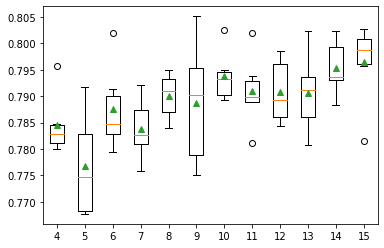

In [11]:

# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

# get the dataset
def get_dataset():
        X, y = train_test2()[0], train_test2()[2]
        return X, y
    
# get a list of models to evaluate
def get_models():
        models = dict()
        for i in range(4,664,4):
            models[str(i)] = RandomForestClassifier(n_estimators=i)
                #rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
                #models = RandomForestClassifier(max_features=i)
                #models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
        return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
        cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=1)
        scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
        return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
        scores = evaluate_model(model, X, y)
        results.append(scores)
        names.append(name)
        print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)


In [56]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics

rfc = RandomForestClassifier(n_estimators=75, max_features=4,max_samples=0.6, random_state=5)
rfc.fit(train_test2()[0], train_test2()[2])
#clf = SVC(C = 1, kernel = 'linear')
#clf.fit(x_train2, y_train2) 
clf2 = SVC(kernel='poly', C=1, coef0=1, degree=5)
clf2.fit(train_test2()[0], train_test2()[2]) 

SVC(C=1, coef0=1, degree=5, kernel='poly')

In [204]:

#### Get row max values
df_max = pd.DataFrame({'max': abs(df.iloc[:,2:]).max(axis=1)})

## Add a column to contain max values from each row
df2 = pd.concat([df1(path1,file2), df_max], axis = 1)
df_bind = df['bind']


In [127]:
df2_drop=df2.drop(columns=['names','bind','max'])
max_values = df2['max']

df2_div = df2_drop.divide(max_values, axis=0)
df2_scaled = pd.concat([df2[['names','bind']],df2_div], axis = 1)

In [128]:
df2_scaled.head()

,names,bind,VDW_0,ELE_0,GB_0,SA_0,VDW_1,ELE_1,GB_1,SA_1,...,GB_163,SA_163,VDW_164,ELE_164,GB_164,SA_164,VDW_165,ELE_165,GB_165,SA_165
0,CBX1-1_1,1,-0.023687,-0.073302,0.041080,-0.003970,-0.025577,-0.064578,0.063390,-0.006860,...,-0.056962,-0.008562,0.003808,0.064902,-0.349251,-0.009480,-0.019392,-1.000000,0.652586,-0.011047
1,CBX1-1_10,1,-0.024464,-0.080057,0.042976,-0.003977,-0.031903,-0.092275,0.086724,-0.007783,...,-0.064521,-0.009185,-0.009642,-0.189185,-0.379714,-0.009557,-0.036624,-0.841144,0.677396,-0.013391
2,CBX1-1_100,1,-0.032261,-0.032713,-0.004589,-0.005076,-0.031775,-0.085660,0.069842,-0.007787,...,-0.085451,-0.010742,-0.001912,-0.675891,0.049296,-0.011333,-0.036642,-1.000000,0.831809,-0.016165
3,CBX1-1_101,0,-0.026858,-0.093437,0.047046,-0.004139,-0.033081,-0.014620,0.008248,-0.007950,...,-0.031533,-0.009886,-0.002233,-0.468973,0.017181,-0.009379,-0.058718,-0.697505,0.680860,-0.017776
4,CBX1-1_102,0,-0.064613,-0.226965,0.114883,-0.009562,-0.091865,-0.260911,0.205587,-0.019193,...,-0.083328,-0.027799,-0.020490,-1.000000,0.114200,-0.023018,-0.109009,-0.232225,-0.085103,-0.038795


In [129]:
df2_ary = np.asarray(df2_scaled.iloc[:,2:])
df2_ary.shape

(5484, 664)

In [130]:
df2_list = df2_scaled.iloc[:,2:].iloc[0].to_numpy().tolist()
df2_scaled.iloc[:,2:].iloc[0]

VDW_0     -0.023687
ELE_0     -0.073302
GB_0       0.041080
SA_0      -0.003970
VDW_1     -0.025577
             ...   
SA_164    -0.009480
VDW_165   -0.019392
ELE_165   -1.000000
GB_165     0.652586
SA_165    -0.011047
Name: 0, Length: 664, dtype: float64

In [131]:
num_rows = df2_scaled.shape[0]
num_cols1 = df2_scaled.shape[1]
num_cols2 = df2_scaled.iloc[:,2:].shape[1]
df2_scaled.shape[0]

5484

In [132]:
ary1 = []
for i in range(num_rows):
    ary1.append(df2_scaled.iloc[:,2:].iloc[i].to_numpy().tolist())

In [133]:
np.asarray(ary1).shape
ary_bindd = np.asarray(df_bind)


In [134]:
ary2 = []
for k in range(len(ary1)):
    hj = [ary1[k][i:i + 4] for i in range(0, len(ary1[k]), 4)]
    ary2.append(hj)
ary3 = np.array(ary2)


In [135]:
from sklearn.model_selection import train_test_split
training_data, testing_data = train_test_split(ary3, test_size=0.1, random_state=10)

x_train3, x_test3, y_train3, y_test3 = train_test_split(ary3, ary_bindd, test_size=0.1, random_state=10)

x_train2, x_test2, y_train2, y_test2 = train_test_split(df2_ary, ary_bindd, test_size=0.1, random_state=10)

In [136]:
tr = np.expand_dims(x_train2, axis=2)
tr.shape

(4935, 664, 1)

In [137]:
import pandas as pd
import tensorflow as tf

from tensorflow.keras import datasets, layers, models, Model
import matplotlib.pyplot as plt

from math import *
from tensorflow import keras

from tensorflow import keras
from keras.models import Model, load_model
from keras.utils.vis_utils import plot_model
#from keras.optimizers import Adam, SGD
from keras.layers import *
from keras.metrics import *
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
#from hyperopt import hp, STATUS_OK

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D, GlobalAveragePooling1D,AveragePooling1D
from keras.preprocessing import sequence
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import LeakyReLU
## sequence.pad_sequence(train_x, maxlen=max_words)
import pickle



In [33]:
from numpy.random import seed
seed(123)


###  Convolutional Layer
layer0 = Input(shape=tr.shape[1:], name='input')
layer1 = Conv1D(filters=16, kernel_size=4, strides=1, kernel_initializer='glorot_normal',activation='relu',name='Conv1D_1')(layer0)
layer2 = BatchNormalization()(layer1)
#model.add(LeakyReLU())
layer3 = MaxPool1D(pool_size=2, strides=2)(layer2)

layer4 = Conv1D(filters=16, kernel_size=4, strides=1, kernel_initializer='glorot_normal',activation='relu',name='Conv1D_2')(layer3)
layer5 = MaxPool1D(pool_size=2, strides=2)(layer4)
layer6 = Dropout(0.5, name='dropout_1')(layer5)

layer7 = Conv1D(filters=10, kernel_size=4, strides=1, kernel_initializer='glorot_normal',activation='relu',name='Conv1D_3')(layer6)
layer8 = AveragePooling1D(pool_size=2, strides=2)(layer7)
layer9 = Dropout(0.5, name='dropout_2')(layer8)

layer10 = Conv1D(filters=8, kernel_size=4, strides=1, kernel_initializer='glorot_normal',activation='relu',name='Conv1D_4')(layer9)
layer11 = AveragePooling1D(pool_size=2, strides=2)(layer10)

layer12 = Conv1D(filters=4, kernel_size=1, strides=1, kernel_initializer='glorot_normal',activation='relu',name='Conv1D_5')(layer11)
layer13 = GlobalAveragePooling1D()(layer12)

layer14 = Flatten(name='Flatten_1')(layer13)
layer15 = Dense(20,activation='relu',name='Dense_1')(layer14)
layer16 = Dropout(0.00099,name='dropout_3')(layer15)
layer17 = Dense(1,activation='relu',name='Dense_3')(layer16)

layer18 = Dropout(0.00099,name='dropout_4')(layer17)

### Contextual regression
layer19 = Dense(166*4,kernel_regularizer=tf.keras.regularizers.l1(0.0001),name='Contextual_Weight')(layer18) ## make first layer
layer20 = Dropout(0.00099,name='dropout_5')(layer19)

#### Dot Product
layer21 = Flatten(name='Flatten_2')(layer0)
layer22 = Multiply()([layer21,layer19]) ## same number of nodes as input feaures

layer23 = Dense(1,kernel_initializer='ones',use_bias=False,name='Sum')(layer22)
layer24 = Dense(1,name='Output')(layer23) 
model = Model(inputs=layer0, outputs=layer24)
model.layers[23].trainable = False
model.summary()
keras.utils.plot_model(model, "model_with_shape_info.png", show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 664, 1)]     0           []                               
                                                                                                  
 Conv1D_1 (Conv1D)              (None, 661, 16)      80          ['input[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 661, 16)     64          ['Conv1D_1[0][0]']               
 alization)                                                                                       
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 330, 16)      0           ['batch_normalization[0][0]']

2022-06-05 21:50:06.227626: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [1]:
### Reduced Model for Simplification

In [233]:
from numpy.random import seed
seed(120)

layer0 = Input(shape=tr.shape[1:], name='input')
layer1 = Conv1D(filters=16, kernel_size=4, strides=1, kernel_initializer='glorot_normal',activation='relu',name='Conv1D_1')(layer0)
layer2 = BatchNormalization()(layer1)
layer3 = MaxPool1D(pool_size=1, strides=1)(layer2)

layer4 = Conv1D(filters=12, kernel_size=4, strides=1, kernel_initializer='glorot_normal',activation='relu', name='Conv1D_2')(layer3)
layer5 = MaxPool1D(pool_size=2, strides=2)(layer4)
layer6 = GlobalAveragePooling1D()(layer5)


layer7 = Flatten(name='Flatten_1')(layer6)
layer8 = Dense(12,activation='relu',name='Dense_1')(layer7)
layer9 = Dropout(0.00099,name='dropout_3')(layer8)
layer10 = Dense(1,activation='relu',name='Dense_3')(layer9)
layer11 = Dropout(0.00099,name='dropout_4')(layer10)

    ### Contextual regression
layer12 = Dense(166*4,kernel_regularizer=tf.keras.regularizers.l1(0.0001),name='Contextual_Weight')(layer11) ## make first layer
layer13 = Dropout(0.00099,name='dropout_5')(layer12)

    #### Dot Product
layer14 = Flatten(name='Flatten_2')(layer0)
layer15 = Multiply()([layer13,layer14]) ## same number of nodes as input feaures

layer16 = Dense(1, activation='sigmoid', kernel_initializer='ones',use_bias=False,name='Sum')(layer15)
layer17 = Dense(1, name='Output')(layer16)

model = Model(inputs=layer0, outputs=layer17)
#model.layers[16].trainable = False

model.summary()



Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 664, 1)]     0           []                               
                                                                                                  
 Conv1D_1 (Conv1D)              (None, 661, 16)      80          ['input[0][0]']                  
                                                                                                  
 batch_normalization_35 (BatchN  (None, 661, 16)     64          ['Conv1D_1[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 max_pooling1d_70 (MaxPooling1D  (None, 661, 16)     0           ['batch_normalization_35[0

In [46]:
from keras import backend as K

input_sig =Input(shape=tr.shape[1:], name='input')
x = Conv1D(64,4, activation='relu', padding='valid')(input_sig)
x1 = MaxPooling1D(2)(x)
x2 = Conv1D(32,4, activation='relu', padding='valid')(x1)
x3 = MaxPooling1D(2)(x2)
flat = Flatten()(x3)
encoded = Dense(32,activation = 'relu')(flat)

print("shape of encoded {}".format(K.int_shape(flat)))

x2_ = Conv1D(32, 4, activation='relu', padding='valid')(x3)
x1_ = UpSampling1D(2)(x2_)
x_ = Conv1D(64, 4, activation='relu', padding='valid')(x1_)
upsamp = UpSampling1D(2)(x_)
flat = Flatten()(upsamp)
decoded = Dense(664,activation = 'relu')(flat)
decoded = Reshape((664,1))(decoded)

print("shape of decoded {}".format(K.int_shape(x1_)))

model = Model(input_sig, decoded)
model.summary()

shape of encoded (None, 5216)
shape of decoded (None, 320, 32)
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 664, 1)]          0         
                                                                 
 conv1d_97 (Conv1D)          (None, 661, 64)           320       
                                                                 
 max_pooling1d_52 (MaxPoolin  (None, 330, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_98 (Conv1D)          (None, 327, 32)           8224      
                                                                 
 max_pooling1d_53 (MaxPoolin  (None, 163, 32)          0         
 g1D)                                                            
                                                             

In [82]:
from tensorflow.keras.optimizers import SGD, Adam
from keras.metrics import *
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping


#model.compile(optimizer='Adam',loss='mse',metrics =['accuracy'])
model.compile(SGD(lr=0.01, momentum=0.9),'mean_squared_error', metrics=['accuracy']) ##, momentum=0.9
earlystop_cb = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')
check_cb = ModelCheckpoint('bestparams2.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(x_train2, y_train2, batch_size=16, epochs=150, validation_split=0.20, callbacks=[check_cb]) 



Epoch 1/150


/stg3/data1/chad/anaconda3/envs/python3.10/lib/python3.10/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


238/247 [===========================>..] - ETA: 0s - loss: 0.1901 - accuracy: 0.7579
Epoch 1: val_loss improved from inf to 0.18833, saving model to bestparams2.h5
247/247 [==============================] - 2s 5ms/step - loss: 0.1897 - accuracy: 0.7586 - val_loss: 0.1883 - val_accuracy: 0.7568
Epoch 2/150
238/247 [===========================>..] - ETA: 0s - loss: 0.1859 - accuracy: 0.7600
Epoch 2: val_loss improved from 0.18833 to 0.18641, saving model to bestparams2.h5
247/247 [==============================] - 1s 4ms/step - loss: 0.1866 - accuracy: 0.7586 - val_loss: 0.1864 - val_accuracy: 0.7568
Epoch 3/150
239/247 [============================>.] - ETA: 0s - loss: 0.1859 - accuracy: 0.7584
Epoch 3: val_loss improved from 0.18641 to 0.18375, saving model to bestparams2.h5
247/247 [==============================] - 1s 4ms/step - loss: 0.1858 - accuracy: 0.7586 - val_loss: 0.1838 - val_accuracy: 0.7568
Epoch 4/150
239/247 [============================>.] - ETA: 0s - loss: 0.1811 - acc

Epoch 29/150
239/247 [============================>.] - ETA: 0s - loss: 0.1543 - accuracy: 0.7806
Epoch 29: val_loss improved from 0.15463 to 0.15331, saving model to bestparams2.h5
247/247 [==============================] - 1s 4ms/step - loss: 0.1543 - accuracy: 0.7806 - val_loss: 0.1533 - val_accuracy: 0.7842
Epoch 30/150
238/247 [===========================>..] - ETA: 0s - loss: 0.1542 - accuracy: 0.7810
Epoch 30: val_loss did not improve from 0.15331
247/247 [==============================] - 1s 4ms/step - loss: 0.1542 - accuracy: 0.7809 - val_loss: 0.1548 - val_accuracy: 0.7842
Epoch 31/150
239/247 [============================>.] - ETA: 0s - loss: 0.1536 - accuracy: 0.7827
Epoch 31: val_loss did not improve from 0.15331
247/247 [==============================] - 1s 4ms/step - loss: 0.1539 - accuracy: 0.7829 - val_loss: 0.1694 - val_accuracy: 0.7670
Epoch 32/150
238/247 [===========================>..] - ETA: 0s - loss: 0.1539 - accuracy: 0.7823
Epoch 32: val_loss did not improve 

Epoch 58/150
239/247 [============================>.] - ETA: 0s - loss: 0.1478 - accuracy: 0.7958
Epoch 58: val_loss did not improve from 0.15072
247/247 [==============================] - 1s 4ms/step - loss: 0.1484 - accuracy: 0.7938 - val_loss: 0.1602 - val_accuracy: 0.7781
Epoch 59/150
239/247 [============================>.] - ETA: 0s - loss: 0.1501 - accuracy: 0.7939
Epoch 59: val_loss did not improve from 0.15072
247/247 [==============================] - 1s 4ms/step - loss: 0.1487 - accuracy: 0.7966 - val_loss: 0.1528 - val_accuracy: 0.7822
Epoch 60/150
238/247 [===========================>..] - ETA: 0s - loss: 0.1475 - accuracy: 0.7991
Epoch 60: val_loss did not improve from 0.15072
247/247 [==============================] - 1s 4ms/step - loss: 0.1478 - accuracy: 0.7989 - val_loss: 0.1542 - val_accuracy: 0.7842
Epoch 61/150
237/247 [===========================>..] - ETA: 0s - loss: 0.1478 - accuracy: 0.7938
Epoch 61: val_loss did not improve from 0.15072
247/247 [==============

247/247 [==============================] - 1s 4ms/step - loss: 0.1420 - accuracy: 0.7989 - val_loss: 0.1500 - val_accuracy: 0.7872
Epoch 117/150
239/247 [============================>.] - ETA: 0s - loss: 0.1434 - accuracy: 0.8018
Epoch 117: val_loss did not improve from 0.14892
247/247 [==============================] - 1s 4ms/step - loss: 0.1433 - accuracy: 0.8017 - val_loss: 0.1494 - val_accuracy: 0.7872
Epoch 118/150
239/247 [============================>.] - ETA: 0s - loss: 0.1405 - accuracy: 0.8044
Epoch 118: val_loss did not improve from 0.14892
247/247 [==============================] - 1s 4ms/step - loss: 0.1398 - accuracy: 0.8052 - val_loss: 0.1649 - val_accuracy: 0.7903
Epoch 119/150
239/247 [============================>.] - ETA: 0s - loss: 0.1431 - accuracy: 0.7997
Epoch 119: val_loss improved from 0.14892 to 0.14858, saving model to bestparams2.h5
247/247 [==============================] - 1s 4ms/step - loss: 0.1429 - accuracy: 0.8002 - val_loss: 0.1486 - val_accuracy: 0.7

Epoch 146/150
238/247 [===========================>..] - ETA: 0s - loss: 0.1420 - accuracy: 0.8046
Epoch 146: val_loss did not improve from 0.14858
247/247 [==============================] - 1s 4ms/step - loss: 0.1416 - accuracy: 0.8057 - val_loss: 0.1560 - val_accuracy: 0.7893
Epoch 147/150
239/247 [============================>.] - ETA: 0s - loss: 0.1398 - accuracy: 0.8054
Epoch 147: val_loss did not improve from 0.14858
247/247 [==============================] - 1s 4ms/step - loss: 0.1394 - accuracy: 0.8067 - val_loss: 0.1533 - val_accuracy: 0.7781
Epoch 148/150
239/247 [============================>.] - ETA: 0s - loss: 0.1417 - accuracy: 0.8002
Epoch 148: val_loss did not improve from 0.14858
247/247 [==============================] - 1s 4ms/step - loss: 0.1411 - accuracy: 0.8009 - val_loss: 0.1509 - val_accuracy: 0.7893
Epoch 149/150
239/247 [============================>.] - ETA: 0s - loss: 0.1385 - accuracy: 0.8060
Epoch 149: val_loss did not improve from 0.14858
247/247 [======

In [319]:
from tensorflow.keras.optimizers import SGD, Adam
from keras.metrics import *
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping


#model.compile(optimizer='Adam',loss='mse',metrics =['accuracy'])
model.compile(SGD(lr=0.01, momentum=0.9),'mean_squared_error', metrics=['accuracy']) ##, momentum=0.9
earlystop_cb = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')
check_cb = ModelCheckpoint('bestparams2.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(x_train2, y_train2, batch_size=16, epochs=150, validation_split=0.20, callbacks=[check_cb]) 



Epoch 1/150
239/247 [============================>.] - ETA: 0s - loss: 0.1999 - accuracy: 0.7500
Epoch 1: val_loss improved from inf to 0.17957, saving model to bestparams2.h5
247/247 [==============================] - 2s 5ms/step - loss: 0.1986 - accuracy: 0.7518 - val_loss: 0.1796 - val_accuracy: 0.7568
Epoch 2/150
239/247 [============================>.] - ETA: 0s - loss: 0.1769 - accuracy: 0.7586
Epoch 2: val_loss improved from 0.17957 to 0.17235, saving model to bestparams2.h5
247/247 [==============================] - 1s 4ms/step - loss: 0.1769 - accuracy: 0.7586 - val_loss: 0.1723 - val_accuracy: 0.7568
Epoch 3/150
239/247 [============================>.] - ETA: 0s - loss: 0.1708 - accuracy: 0.7599
Epoch 3: val_loss improved from 0.17235 to 0.16688, saving model to bestparams2.h5
247/247 [==============================] - 1s 4ms/step - loss: 0.1701 - accuracy: 0.7611 - val_loss: 0.1669 - val_accuracy: 0.7609
Epoch 4/150
239/247 [============================>.] - ETA: 0s - loss: 

Epoch 29/150
239/247 [============================>.] - ETA: 0s - loss: 0.1546 - accuracy: 0.7769
Epoch 29: val_loss did not improve from 0.15535
247/247 [==============================] - 1s 4ms/step - loss: 0.1545 - accuracy: 0.7774 - val_loss: 0.1555 - val_accuracy: 0.7720
Epoch 30/150
239/247 [============================>.] - ETA: 0s - loss: 0.1550 - accuracy: 0.7775
Epoch 30: val_loss did not improve from 0.15535
247/247 [==============================] - 1s 4ms/step - loss: 0.1547 - accuracy: 0.7768 - val_loss: 0.1566 - val_accuracy: 0.7720
Epoch 31/150
239/247 [============================>.] - ETA: 0s - loss: 0.1541 - accuracy: 0.7767
Epoch 31: val_loss did not improve from 0.15535
247/247 [==============================] - 1s 4ms/step - loss: 0.1546 - accuracy: 0.7761 - val_loss: 0.1557 - val_accuracy: 0.7741
Epoch 32/150
239/247 [============================>.] - ETA: 0s - loss: 0.1541 - accuracy: 0.7806
Epoch 32: val_loss did not improve from 0.15535
247/247 [==============

247/247 [==============================] - 1s 4ms/step - loss: 0.1437 - accuracy: 0.7946 - val_loss: 0.1540 - val_accuracy: 0.7913
Epoch 87/150
239/247 [============================>.] - ETA: 0s - loss: 0.1440 - accuracy: 0.7931
Epoch 87: val_loss improved from 0.15018 to 0.14839, saving model to bestparams2.h5
247/247 [==============================] - 1s 4ms/step - loss: 0.1435 - accuracy: 0.7936 - val_loss: 0.1484 - val_accuracy: 0.7862
Epoch 88/150
239/247 [============================>.] - ETA: 0s - loss: 0.1433 - accuracy: 0.7947
Epoch 88: val_loss did not improve from 0.14839
247/247 [==============================] - 1s 4ms/step - loss: 0.1439 - accuracy: 0.7938 - val_loss: 0.1561 - val_accuracy: 0.7974
Epoch 89/150
239/247 [============================>.] - ETA: 0s - loss: 0.1452 - accuracy: 0.7950
Epoch 89: val_loss did not improve from 0.14839
247/247 [==============================] - 1s 4ms/step - loss: 0.1441 - accuracy: 0.7964 - val_loss: 0.1495 - val_accuracy: 0.7842
Ep

Epoch 116/150
239/247 [============================>.] - ETA: 0s - loss: 0.1420 - accuracy: 0.8010
Epoch 116: val_loss did not improve from 0.14739
247/247 [==============================] - 1s 4ms/step - loss: 0.1416 - accuracy: 0.7994 - val_loss: 0.1499 - val_accuracy: 0.7822
Epoch 117/150
239/247 [============================>.] - ETA: 0s - loss: 0.1416 - accuracy: 0.7994
Epoch 117: val_loss did not improve from 0.14739
247/247 [==============================] - 1s 4ms/step - loss: 0.1419 - accuracy: 0.7986 - val_loss: 0.1480 - val_accuracy: 0.7913
Epoch 118/150
239/247 [============================>.] - ETA: 0s - loss: 0.1408 - accuracy: 0.7981
Epoch 118: val_loss did not improve from 0.14739
247/247 [==============================] - 1s 4ms/step - loss: 0.1413 - accuracy: 0.7971 - val_loss: 0.1480 - val_accuracy: 0.7832
Epoch 119/150
238/247 [===========================>..] - ETA: 0s - loss: 0.1402 - accuracy: 0.7978
Epoch 119: val_loss did not improve from 0.14739
247/247 [======

Epoch 145/150
239/247 [============================>.] - ETA: 0s - loss: 0.1391 - accuracy: 0.8018
Epoch 145: val_loss did not improve from 0.14720
247/247 [==============================] - 1s 4ms/step - loss: 0.1397 - accuracy: 0.8017 - val_loss: 0.1558 - val_accuracy: 0.7822
Epoch 146/150
239/247 [============================>.] - ETA: 0s - loss: 0.1402 - accuracy: 0.8002
Epoch 146: val_loss did not improve from 0.14720
247/247 [==============================] - 1s 4ms/step - loss: 0.1403 - accuracy: 0.7999 - val_loss: 0.1496 - val_accuracy: 0.7812
Epoch 147/150
239/247 [============================>.] - ETA: 0s - loss: 0.1384 - accuracy: 0.8023
Epoch 147: val_loss did not improve from 0.14720
247/247 [==============================] - 1s 4ms/step - loss: 0.1388 - accuracy: 0.8019 - val_loss: 0.1481 - val_accuracy: 0.7943
Epoch 148/150
239/247 [============================>.] - ETA: 0s - loss: 0.1395 - accuracy: 0.7986
Epoch 148: val_loss did not improve from 0.14720
247/247 [======

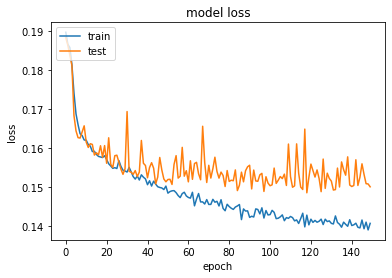

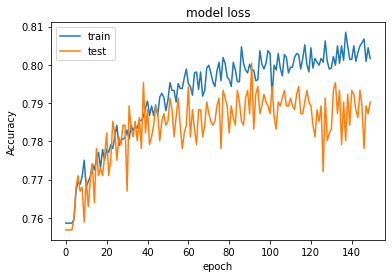

In [83]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [321]:
model.save_weights('cnn.h5')


In [84]:
pre = abs(np.asarray(model.predict(x_test2).round()))
y_test2
ld = [x[0] for x in pre]
ints = [int(item) for item in ld]
pre_ary = np.array(ints)



sub_ary = y_test2 - pre_ary

cnt = np.count_nonzero(sub_ary)

num = ((cnt)/y_test2.shape[0] *100)
perc_acc =  ((y_test2.shape[0] - cnt)/y_test2.shape[0] *100)
round(num,2)

print("count mismatch:",cnt,"   out of:",y_test3.shape[0],"  % mismatch:",round(num,2), "  accuracy",round(perc_acc,2))

count mismatch: 97    out of: 549   % mismatch: 17.67   accuracy 82.33


In [85]:
gh = model.get_layer(name='Contextual_Weight').get_weights()[0][0]
gh2 = model.get_layer(name='Contextual_Weight').get_weights()[1]
df2 = pd.DataFrame(gh).T
df2

,0,1,2,3,4,5,6,7,8,9,...,654,655,656,657,658,659,660,661,662,663
0,0.000394,0.002912,-0.095282,0.000022,0.00031,-0.008533,0.153238,0.000012,0.000779,0.152432,...,-0.171184,0.000012,0.000043,-0.869785,-0.033196,-0.000038,0.001141,-0.463337,-0.994885,0.000072


In [86]:
from itertools import groupby

def four_inter2(data):
    df = []
#    print(data)
    df = data
    c_ln = int(df.shape[1])
    n_dim = c_ln/4
    
    lt = ["VDW", "ELE", "GB", "SA"]
    op = []
    
    for k, j in enumerate(lt):
        if lt[k] == j:
            for i in range(int(n_dim)):
                f = j + "_" + str(i)
                op.append(f)
            
            
    res = [list(i) for j, i in groupby(op, lambda a: a.split('_')[0])]
    ddf1 = pd.DataFrame(res[0])
    ddf2 = pd.DataFrame(res[1])
    ddf3 = pd.DataFrame(res[2])
    ddf4 = pd.DataFrame(res[3])
    
    column_names = pd.concat([ddf1,ddf2,ddf3,ddf4], axis=1).to_numpy().flatten().tolist()

    lt_col = column_names
    
    return lt_col

In [87]:
## Note df2 is renamed for weights...
df2.columns = four_inter2(df2)
df_abs = abs(df2)
df_abs.sort_values(by=0, ascending=False,axis=1)

,GB_165,ELE_164,GB_67,ELE_67,GB_83,GB_49,ELE_83,ELE_49,VDW_53,ELE_80,...,VDW_75,SA_42,VDW_25,SA_64,SA_41,VDW_86,VDW_92,SA_90,SA_85,SA_107
0,0.994885,0.869785,0.776263,0.687331,0.544226,0.526459,0.523596,0.511166,0.492182,0.487036,...,1.474301e-07,1.161969e-07,1.154306e-07,9.814556e-08,9.268399e-08,5.395361e-08,4.053800e-08,3.607749e-08,2.188256e-08,8.000313e-09


In [88]:
#pd.read_csv(path1+file2, delimiter=' ',names=four_inter(df))
#pd.DataFrame(gh).T
df2.columns = four_inter2(df2)
df_abs = abs(df2)

df_rk = df_abs.sort_values(by=0, ascending=False,axis=1)
df_rk = round(df_rk.iloc[:,0:30],15)
df_rkw = pd.DataFrame(df_rk.iloc[0]).reset_index()[0]
df_rkw = pd.DataFrame(df_rkw)
df_rkw.columns = ['weights']
df_rkw

,weights
0,0.994885
1,0.869785
2,0.776263
3,0.687331
4,0.544226
5,0.526459
6,0.523596
7,0.511166
8,0.492182
9,0.487036


<AxesSubplot:>

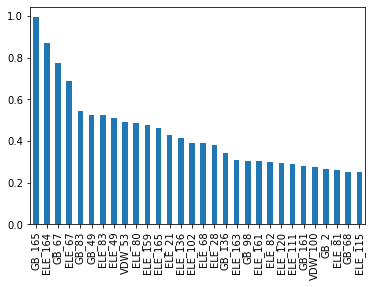

In [89]:
df_rk.T.plot(kind= 'bar',rot=90, legend=None)

In [90]:
file3 = 'generalizePairDist_15A_noH_10A.list'
df5 = pd.read_csv(path1+file3, sep='\\t', header=None)
df5.columns = ['res1','res2','prot_res','lig_res','arb1','dist','arb2']

/tmp/ipykernel_1532965/1802899870.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df5 = pd.read_csv(path1+file3, sep='\\t', header=None)


In [91]:
df_rk.columns
df_2lt = list(df_rk.columns)

df_2lt
int_term = []
int_pair = []
for i in range(len(df_2lt)):
#    print(df_2lt[i].split('_'))
    int_term.append(df_2lt[i].split('_')[0])
    int_pair.append(df_2lt[i].split('_')[1])
    
#np.sort(int_pair)
#sorted(int_pair, key=int, reverse=False)

## Put them into DFs in case needed....
INT_TERM = pd.DataFrame(int_term, columns=['terms'])
INT_PAIR = pd.DataFrame(int_pair, columns=['pair'])

pd.concat([INT_TERM,INT_PAIR], axis=1)


## We need to even out vectors...so lets Filter data base on the limit of DF5
lt_pr = []
ind = []

for j in int_pair:
    j = int(j)
    if j < df5.shape[0]:
        lt_pr.append(df5.iloc[j])
 #       ind.append(df_rk.iloc[j]) 
        

lt_pr[0]        
#ind[0]
int_pair
f = pd.DataFrame(lt_pr)
g = pd.DataFrame(df_rk.columns,columns=['terms'])
#h = pd.DataFrame()
#pd.concat([g,f])
                 
##split data in into different columns

h = pd.DataFrame(int_term, columns=['int_term'])
gh = pd.concat([g,h,df_rkw],axis=1)
gh


df_en = df[gh['terms']]

df_en_sc = df_en.multiply(np.array(df_rkw.T), axis='columns')
df_en.multiply(np.array(df_rkw.T), axis='columns')

,GB_165,ELE_164,GB_67,ELE_67,GB_83,GB_49,ELE_83,ELE_49,VDW_53,ELE_80,...,ELE_161,ELE_82,ELE_120,ELE_111,GB_161,VDW_100,GB_2,ELE_81,GB_68,ELE_115
0,24.038422,2.090094,0.492927,-0.441954,10.152541,-5.085066,-9.888102,5.000738,-0.265778,11.289004,...,-1.828035,-0.236113,-0.431237,-1.751152,0.199649,-0.230889,-0.067385,-3.948177,2.267362,-0.150962
1,23.553913,-5.751021,0.417630,-0.374596,10.037710,-4.804463,-9.775529,4.726242,-0.240677,10.835573,...,-1.824414,-0.227712,-0.520882,-1.691283,0.196595,-0.229244,-0.061836,-3.695005,2.145101,-0.159474
2,23.804624,-16.910368,0.404433,-0.362911,0.440279,-4.731285,-0.427254,4.653656,-0.510393,10.441561,...,-3.427980,-7.518700,-0.053026,-0.464844,0.310997,-0.436551,-0.105173,-3.682477,2.120700,-3.555238
3,22.749051,-13.699120,0.427721,-0.384218,0.918654,-4.787616,-0.890112,4.709373,-0.462159,10.377760,...,1.192944,-0.254414,-0.312002,6.592149,-4.780475,-0.411049,0.028540,-3.762343,2.138561,3.309894
4,-1.239627,-12.734528,0.440918,-0.395216,0.259596,-4.793407,-0.252373,4.715507,-0.488244,1.391461,...,-1.794545,-0.189010,-0.207708,-0.307689,0.018049,-0.314251,-0.096453,-3.764170,2.157177,-0.133938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5479,19.545519,-15.887501,0.759186,-0.687331,-1.171719,-7.396220,1.307418,7.311209,-0.417370,11.290952,...,-3.503406,-6.435942,-0.326064,-0.748068,0.181323,-0.205387,-0.025104,-6.657638,3.294254,2.969667
5480,20.924431,-15.802262,0.758409,-0.687331,-1.625060,-7.401484,1.669746,7.319387,-0.416386,13.043794,...,-3.375483,-6.068123,-0.520003,-0.609046,0.216032,-0.201000,-0.011363,-6.140854,3.278908,-0.035550
5481,19.526617,-14.530635,0.787907,-0.714825,-1.502065,-7.516779,1.622099,7.435422,-0.428198,11.377157,...,-5.443977,-0.330618,-0.443541,-0.959910,-0.036653,-0.230889,-0.016912,-6.633887,3.337272,-3.305388
5482,19.227156,-16.071025,0.800327,-0.726509,-1.549956,-7.539416,1.773942,7.457913,-0.340590,11.228611,...,-4.137592,-0.290115,-0.357411,-1.162254,-0.080804,-0.103379,0.672264,-6.784485,3.361925,3.065551


In [92]:
df_en_sc= pd.concat([df[['names','bind']],df_en_sc], axis = 1)

In [93]:
df_en_sc['Sum'] = df_en_sc.sum(axis=1)
df_en_sc[['bind','Sum']]

df_en['Sum'] = df_en.sum(axis=1)

/tmp/ipykernel_1532965/3369454623.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_en_sc['Sum'] = df_en_sc.sum(axis=1)
/tmp/ipykernel_1532965/3369454623.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en['Sum'] = df_en.sum(axis=1)


# Free energy

In [94]:
bar1 = df_en_sc.groupby(df_en_sc['Sum'].apply(lambda x: 'binding' if x < 0 else 'nonbinding' ))['Sum'].count()
bar2 = df_en.groupby(df_en['Sum'].apply(lambda x: 'binding' if x < 0 else 'nonbinding' ))['Sum'].count()
bar3 = df_en_sc.groupby(df_en_sc['bind'].apply(lambda x: 'binding' if x <= 0 else 'nonbinding'  ))['bind'].count()

print(bar1, bar2, bar3)

print("% Error_wt:", ((bar3.values[0]-bar1.values[0])/bar3.values[0]).round(3)*100,
      "% Error_Nowt",((abs(bar3.values[0]-bar2.values[0])/bar3.values[0])*100).round(3))

Sum
binding       4477
nonbinding    1007
Name: Sum, dtype: int64 Sum
binding       5252
nonbinding     232
Name: Sum, dtype: int64 bind
binding       4179
nonbinding    1305
Name: bind, dtype: int64
% Error_wt: -7.1 % Error_Nowt 25.676


In [95]:
bar1

Sum
binding       4477
nonbinding    1007
Name: Sum, dtype: int64

In [96]:


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

bar1['hue']="weight"
bar2['hue']="NonWt"
bar3['hue']="true"
res=pd.concat([bar1, bar2, bar3])
#(x='binding',y='nonbinding',data=res,hue='hue')


#  MIEC with Some Selected MIEC data

In [97]:
gh['pos'] = gh['terms'].str.split('_', expand=True).iloc[:,1].astype(int)
#g.reset_index()
gh['energy_nowt'] = pd.DataFrame(df_en.drop(columns=['Sum']).iloc[1]).values
gh['energy_wt'] = df_en_sc.iloc[:,2:-1].iloc[0].values
gh = gh[gh['pos'] < int(df5.shape[0])].reset_index()

f = f.reset_index()
gg=pd.concat([gh,f], axis = 1)
gg = gg[['terms','int_term','pos','prot_res','lig_res','dist','weights','energy_nowt','energy_wt']]

gg
#pd.concat([gg, df_en.drop(columns=['Sum']).iloc[0].reset_index()], axis=1)

,terms,int_term,pos,prot_res,lig_res,dist,weights,energy_nowt,energy_wt
0,GB_67,GB,67,28.0,-1.0,7.932,0.776263,0.538,0.492927
1,ELE_67,ELE,67,28.0,-1.0,7.932,0.687331,-0.545,-0.441954
2,GB_83,GB,83,35.0,-2.0,5.410,0.544226,18.444,10.152541
3,GB_49,GB,49,23.0,-1.0,7.567,0.526459,-9.126,-5.085066
4,ELE_83,ELE,83,35.0,-2.0,5.410,0.523596,-18.670,-9.888102
5,ELE_49,ELE,49,23.0,-1.0,7.567,0.511166,9.246,5.000738
6,VDW_53,VDW,53,24.0,-3.0,3.583,0.492182,-0.489,-0.265778
7,ELE_80,ELE,80,35.0,0.0,5.422,0.487036,22.248,11.289004
8,ELE_21,ELE,21,4.0,-5.0,3.068,0.429386,-5.782,-2.485716
9,ELE_136,ELE,136,45.0,-6.0,5.671,0.411765,-11.586,-5.037529


In [98]:
gg

,terms,int_term,pos,prot_res,lig_res,dist,weights,energy_nowt,energy_wt
0,GB_67,GB,67,28.0,-1.0,7.932,0.776263,0.538,0.492927
1,ELE_67,ELE,67,28.0,-1.0,7.932,0.687331,-0.545,-0.441954
2,GB_83,GB,83,35.0,-2.0,5.410,0.544226,18.444,10.152541
3,GB_49,GB,49,23.0,-1.0,7.567,0.526459,-9.126,-5.085066
4,ELE_83,ELE,83,35.0,-2.0,5.410,0.523596,-18.670,-9.888102
5,ELE_49,ELE,49,23.0,-1.0,7.567,0.511166,9.246,5.000738
6,VDW_53,VDW,53,24.0,-3.0,3.583,0.492182,-0.489,-0.265778
7,ELE_80,ELE,80,35.0,0.0,5.422,0.487036,22.248,11.289004
8,ELE_21,ELE,21,4.0,-5.0,3.068,0.429386,-5.782,-2.485716
9,ELE_136,ELE,136,45.0,-6.0,5.671,0.411765,-11.586,-5.037529


In [99]:
y_pred = model.predict(x_test2)

In [100]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics

rfc = RandomForestClassifier(n_estimators=75, max_features=4,max_samples=0.6, random_state=5)
rfc.fit(x_train2, y_train2)
#clf = SVC(C = 1, kernel = 'linear')
#clf.fit(x_train2, y_train2) 
clf2 = SVC(kernel='poly', C=1, coef0=1, degree=5)
clf2.fit(x_train2, y_train2) 

SVC(C=1, coef0=1, degree=5, kernel='poly')

In [37]:
clf2.best_estimator_

AttributeError: 'SVC' object has no attribute 'best_estimator_'

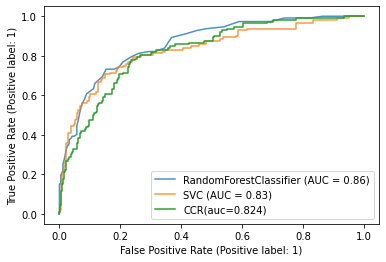

In [101]:
#rfc = RandomForestClassifier(n_estimators=10, random_state=42)
#rfc.fit(X_train, y_train)
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics

ax = plt.gca()
rfc_y_pred_proba = rfc.predict_proba(x_test2)
rfc_y_pred_proba_positive = rfc_y_pred_proba[:, 1] 


rfc_disp = RocCurveDisplay.from_estimator(rfc, x_test2, y_test2, ax=ax, alpha=0.8)
#clf_disp = RocCurveDisplay.from_estimator(clf, x_test2, y_test2, ax=ax, alpha=0.8)
clf2_disp = RocCurveDisplay.from_estimator(clf2, x_test2, y_test2, ax=ax, alpha=0.8)

y_pred= model.predict(x_test2)
fpr, tpr, _ = metrics.roc_curve(y_test2,  y_pred)
auc = metrics.roc_auc_score(y_test2, y_pred)
plt.plot(fpr,tpr,label="CCR(auc="+str(auc.round(3))+")")
plt.legend(loc=4)

plt.show()

In [300]:
#fpr, tpr, thresholds = metrics.roc_curve(y_test2, model.predict(x_test2))
#roc_auc = metrics.auc(fpr, tpr)
#display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
#display.plot()
#plt.show()

In [302]:
#clf.predict(x_test2)
#rfc_pred = rfc.predict(x_test2)

In [301]:
#y_test2 - rfc_pred

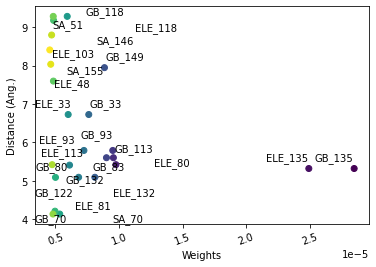

In [333]:
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

#sns.lmplot(data=gg, x='weights', y='dist', hue='terms', legend = False )
#sns.lineplot(data=gg, x='weights', y='dist', hue='terms',legend=None)
fig, ax = plt.subplots()

p1 = ax.scatter(gg['weights'],gg['dist'],c=pd.factorize(gg['terms'])[0])

texts = []
for i, txt in enumerate(gg['terms']):
    texts.append(ax.annotate(txt, xy=(gg['weights'][i], gg['dist'][i]),\
                             xytext=(gg['weights'][i],gg['dist'][i]+.1), size=10, rotation=0))
    
adjust_text(texts)
plt.xticks(rotation=20)
plt.xlabel('Weights')
plt.ylabel('Distance (Ang.)')
#plt.xlim(0.003,0.009)
#plt.ylim(3, 11)

#sns.lmplot(x = 'weights', y='dist', data = gg, line_kws={'color': 'g'})
# Annotate label points 
#for i, language in enumerate(gg['terms']):
#    text.append(.annotate(language,xy= (gg['weights'][i], gg['dist'][i]), textcoords='offset points',\
#                 xytext=(10, 10), rotation=45, ha = 'right', va = 'center',size=14)
plt.show()

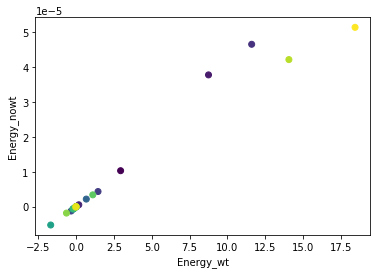

In [368]:
plt.scatter(gg['energy_nowt'],gg['energy_wt'],c=pd.factorize(gg['terms'])[0])
plt.xlabel("Energy_wt")
plt.ylabel("Energy_nowt")
plt.show()

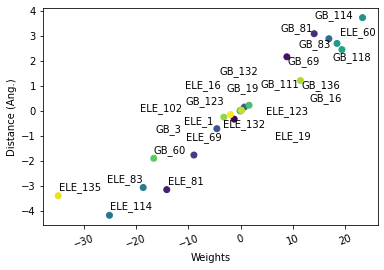

In [312]:
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

#sns.lmplot(data=gg, x='weights', y='dist', hue='terms', legend = False )
#sns.lineplot(data=gg, x='weights', y='dist', hue='terms',legend=None)
fig, ax = plt.subplots()

p1 = ax.scatter(gg['energy_nowt'],gg['energy_wt'],c=pd.factorize(gg['terms'])[0])

texts = []
for i, txt in enumerate(gg['terms']):
    texts.append(ax.annotate(txt, xy=(gg['energy_nowt'][i], gg['energy_wt'][i]),\
                             xytext=(gg['energy_nowt'][i],gg['energy_wt'][i]+.1), size=10, rotation=0))
    
adjust_text(texts)
plt.xticks(rotation=20)
plt.xlabel('Weights')
plt.ylabel('Distance (Ang.)')
#plt.xlim(0.003,0.009)
#plt.ylim(3, 11)

#sns.lmplot(x = 'weights', y='dist', data = gg, line_kws={'color': 'g'})
# Annotate label points 
#for i, language in enumerate(gg['terms']):
#    text.append(.annotate(language,xy= (gg['weights'][i], gg['dist'][i]), textcoords='offset points',\
#                 xytext=(10, 10), rotation=45, ha = 'right', va = 'center',size=14)
plt.show()

>2 0.683 (0.008)
>3 0.699 (0.006)
>4 0.707 (0.003)
>5 0.720 (0.011)
>6 0.717 (0.004)
>7 0.727 (0.009)
>8 0.725 (0.006)
>9 0.730 (0.006)


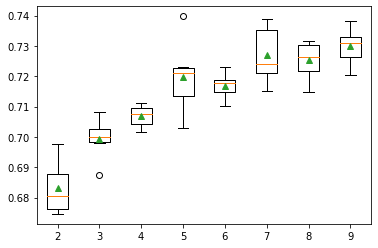

In [37]:
# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
 
# get the dataset
def get_dataset():
	X, y = x_train2, y_train2
	return X, y
 
# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(2, 10):
		rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
		model = DecisionTreeClassifier()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.savefig('RandomForest.png')
pyplot.show()

In [106]:
# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
 
# get the dataset
def get_dataset():
	X, y = x_train2, y_train2
	return X, y
 
# get a list of models to evaluate
def get_models():
#	models = dict()
#	for i in range(2, 10):
#		rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
#		model = DecisionTreeClassifier()
#		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    layer0 = Input(shape=tr.shape[1:], name='input')
    layer1 = Conv1D(filters=16, kernel_size=4, strides=1, kernel_initializer='glorot_normal',activation='relu',name='Conv1D_1')(layer0)
    layer2 = BatchNormalization()(layer1)
    layer3 = MaxPool1D(pool_size=1, strides=1)(layer2)

    layer4 = Conv1D(filters=12, kernel_size=4, strides=1, kernel_initializer='glorot_normal',activation='relu', name='Conv1D_2')(layer3)
    layer5 = MaxPool1D(pool_size=2, strides=2)(layer4)
    layer6 = GlobalAveragePooling1D()(layer5)


    layer7 = Flatten(name='Flatten_1')(layer6)
    layer8 = Dense(12,activation='relu',name='Dense_1')(layer7)
    layer9 = Dropout(0.00099,name='dropout_3')(layer8)
    layer10 = Dense(1,activation='relu',name='Dense_3')(layer9)
    layer11 = Dropout(0.00099,name='dropout_4')(layer10)

    ### Contextual regression
    layer12 = Dense(166*4,kernel_regularizer=tf.keras.regularizers.l1(0.0001),name='Contextual_Weight')(layer11) ## make first layer
    layer13 = Dropout(0.00099,name='dropout_5')(layer12)

    #### Dot Product
    layer14 = Flatten(name='Flatten_2')(layer0)
    layer15 = Multiply()([layer13,layer14]) ## same number of nodes as input feaures

    layer16 = Dense(1, activation='sigmoid', kernel_initializer='ones',use_bias=False,name='Sum')(layer15)
    layer17 = Dense(1, name='Output')(layer16)

    model = Model(inputs=layer0, outputs=layer17)
    #model.layers[16].trainable = False

    models.summary()
    models.compile(loss='mse', optimizer='adam', metrics=['accuracy'])


    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.savefig('RandomForest.png')
pyplot.show()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 664, 1)]     0           []                               
                                                                                                  
 Conv1D_1 (Conv1D)              (None, 661, 16)      80          ['input[0][0]']                  
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 661, 16)     64          ['Conv1D_1[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 max_pooling1d_8 (MaxPooling1D)  (None, 661, 16)     0           ['batch_normalization_4[0][

AttributeError: 'Functional' object has no attribute 'items'

In [139]:

# compare the number of repeats for repeated k-fold cross-validation
from scipy.stats import sem
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
 
# evaluate a model with a given number of repeats
def evaluate_model(X, y, repeats):
	# prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=1)
    # create model
    layer0 = Input(shape=tr.shape[1:], name='input')
    layer1 = Conv1D(filters=16, kernel_size=4, strides=1, kernel_initializer='glorot_normal',activation='relu',name='Conv1D_1')(layer0)
    layer2 = BatchNormalization()(layer1)
    layer3 = MaxPool1D(pool_size=1, strides=1)(layer2)

    layer4 = Conv1D(filters=12, kernel_size=4, strides=1, kernel_initializer='glorot_normal',activation='relu', name='Conv1D_2')(layer3)
    layer5 = MaxPool1D(pool_size=2, strides=2)(layer4)
    layer6 = GlobalAveragePooling1D()(layer5)


    layer7 = Flatten(name='Flatten_1')(layer6)
    layer8 = Dense(12,activation='relu',name='Dense_1')(layer7)
    layer9 = Dropout(0.00099,name='dropout_3')(layer8)
    layer10 = Dense(1,activation='relu',name='Dense_3')(layer9)
    layer11 = Dropout(0.00099,name='dropout_4')(layer10)

    ### Contextual regression
    layer12 = Dense(166*4,kernel_regularizer=tf.keras.regularizers.l1(0.0001),name='Contextual_Weight')(layer11) ## make first layer
    layer13 = Dropout(0.00099,name='dropout_5')(layer12)

    #### Dot Product
    layer14 = Flatten(name='Flatten_2')(layer0)
    layer15 = Multiply()([layer13,layer14]) ## same number of nodes as input feaures

    layer16 = Dense(1, activation='sigmoid', kernel_initializer='ones',use_bias=False,name='Sum')(layer15)
    layer17 = Dense(1, name='Output')(layer16)

    model = Model(inputs=layer0, outputs=layer17)
    #model.layers[16].trainable = False

    model.summary()
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    model.fit(x_train2, y_train2, batch_size=16, epochs=150, validation_split=0.20)
    
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1,verbose=0)
    return scores
 
# create dataset
X, y = x_train2, y_train2
# configurations to test
repeats = range(1,5)
results = list()
for r in repeats:
    # evaluate using a given number of repeats
    scores = evaluate_model(X, y, r)
    # summarize
    print('>%d mean=%.4f se=%.3f' % (r, mean(scores), sem(scores)))
    # store
    results.append(scores)
# plot the results
pyplot.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
pyplot.show()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 664, 1)]     0           []                               
                                                                                                  
 Conv1D_1 (Conv1D)              (None, 661, 16)      80          ['input[0][0]']                  
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 661, 16)     64          ['Conv1D_1[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 max_pooling1d_18 (MaxPooling1D  (None, 661, 16)     0           ['batch_normalization_9[0][

247/247 [==============================] - 1s 4ms/step - loss: 0.1433 - accuracy: 0.8027 - val_loss: 0.1537 - val_accuracy: 0.7822
Epoch 26/150
247/247 [==============================] - 1s 4ms/step - loss: 0.1430 - accuracy: 0.8009 - val_loss: 0.1513 - val_accuracy: 0.7923
Epoch 27/150
247/247 [==============================] - 1s 4ms/step - loss: 0.1433 - accuracy: 0.7986 - val_loss: 0.1511 - val_accuracy: 0.7832
Epoch 28/150
247/247 [==============================] - 1s 4ms/step - loss: 0.1415 - accuracy: 0.8027 - val_loss: 0.1538 - val_accuracy: 0.7964
Epoch 29/150
247/247 [==============================] - 1s 4ms/step - loss: 0.1419 - accuracy: 0.8007 - val_loss: 0.1516 - val_accuracy: 0.7872
Epoch 30/150
247/247 [==============================] - 1s 4ms/step - loss: 0.1416 - accuracy: 0.8047 - val_loss: 0.1519 - val_accuracy: 0.7943
Epoch 31/150
247/247 [==============================] - 1s 4ms/step - loss: 0.1415 - accuracy: 0.8067 - val_loss: 0.1521 - val_accuracy: 0.7832
Epoch

Epoch 82/150
247/247 [==============================] - 1s 4ms/step - loss: 0.1342 - accuracy: 0.8121 - val_loss: 0.1473 - val_accuracy: 0.7953
Epoch 83/150
247/247 [==============================] - 1s 4ms/step - loss: 0.1336 - accuracy: 0.8176 - val_loss: 0.1498 - val_accuracy: 0.7842
Epoch 84/150
247/247 [==============================] - 1s 4ms/step - loss: 0.1343 - accuracy: 0.8128 - val_loss: 0.1465 - val_accuracy: 0.7872
Epoch 85/150
247/247 [==============================] - 1s 4ms/step - loss: 0.1345 - accuracy: 0.8118 - val_loss: 0.1516 - val_accuracy: 0.7903
Epoch 86/150
247/247 [==============================] - 1s 4ms/step - loss: 0.1336 - accuracy: 0.8131 - val_loss: 0.1519 - val_accuracy: 0.7872
Epoch 87/150
247/247 [==============================] - 1s 4ms/step - loss: 0.1332 - accuracy: 0.8197 - val_loss: 0.1495 - val_accuracy: 0.7913
Epoch 88/150
247/247 [==============================] - 1s 4ms/step - loss: 0.1336 - accuracy: 0.8197 - val_loss: 0.1490 - val_accuracy:

TypeError: Cannot clone object '<keras.engine.functional.Functional object at 0x7fd7b06e4d90>' (type <class 'keras.engine.functional.Functional'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [147]:
# Function to create model, required for KerasClassifier
def create_model(filter1=1, filter2=1, filter3=1, filter4=1, filter5=1, stride1=1, stride2=1):#neurons1=1, neurons2=1):
    layer0 = Input(shape=tr.shape[1:], name='input')
    layer1 = Conv1D(filters=16, kernel_size=4, strides=1, kernel_initializer='glorot_normal',activation='relu',name='Conv1D_1')(layer0)
    layer2 = BatchNormalization()(layer1)
    layer3 = MaxPool1D(pool_size=1, strides=1)(layer2)

    layer4 = Conv1D(filters=12, kernel_size=4, strides=1, kernel_initializer='glorot_normal',activation='relu', name='Conv1D_2')(layer3)
    layer5 = MaxPool1D(pool_size=2, strides=2)(layer4)
    layer6 = GlobalAveragePooling1D()(layer5)


    layer7 = Flatten(name='Flatten_1')(layer6)
    layer8 = Dense(12,activation='relu',name='Dense_1')(layer7)
    layer9 = Dropout(0.00099,name='dropout_3')(layer8)
    layer10 = Dense(1,activation='relu',name='Dense_3')(layer9)
    layer11 = Dropout(0.00099,name='dropout_4')(layer10)

    ### Contextual regression
    layer12 = Dense(166*4,kernel_regularizer=tf.keras.regularizers.l1(0.0001),name='Contextual_Weight')(layer11) ## make first layer
    layer13 = Dropout(0.00099,name='dropout_5')(layer12)

    #### Dot Product
    layer14 = Flatten(name='Flatten_2')(layer0)
    layer15 = Multiply()([layer13,layer14]) ## same number of nodes as input feaures

    layer16 = Dense(1, activation='sigmoid', kernel_initializer='ones',use_bias=False,name='Sum')(layer15)
    layer17 = Dense(1, name='Output')(layer16)

    model = Model(inputs=layer0, outputs=layer17)
    return model

In [230]:
def define_model():
    layer0 = Input(shape=tr.shape[1:], name='input')
    layer1 = Conv1D(filters=16, kernel_size=4, strides=1, kernel_initializer='glorot_normal',activation='relu',name='Conv1D_1')(layer0)
    layer2 = BatchNormalization()(layer1)
    layer3 = MaxPool1D(pool_size=1, strides=1)(layer2)

    layer4 = Conv1D(filters=12, kernel_size=4, strides=1, kernel_initializer='glorot_normal',activation='relu', name='Conv1D_2')(layer3)
    layer5 = MaxPool1D(pool_size=2, strides=2)(layer4)
    layer6 = GlobalAveragePooling1D()(layer5)


    layer7 = Flatten(name='Flatten_1')(layer6)
    layer8 = Dense(12,activation='relu',name='Dense_1')(layer7)
    layer9 = Dropout(0.00099,name='dropout_3')(layer8)
    layer10 = Dense(1,activation='relu',name='Dense_3')(layer9)
    layer11 = Dropout(0.00099,name='dropout_4')(layer10)

    ### Contextual regression
    layer12 = Dense(166*4,kernel_regularizer=tf.keras.regularizers.l1(0.0001),name='Contextual_Weight')(layer11) ## make first layer
    layer13 = Dropout(0.00099,name='dropout_5')(layer12)

    #### Dot Product
    layer14 = Flatten(name='Flatten_2')(layer0)
    layer15 = Multiply()([layer13,layer14]) ## same number of nodes as input feaures

#    layer16 = Dense(1, activation='sigmoid', kernel_initializer='ones',use_bias=False,name='Sum')(layer15)
    layer17 = Dense(1, activation='sigmoid', name='Output')(layer16)

    model = Model(inputs=layer0, outputs=layer17)
    #model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    model.compile(SGD(lr=0.01, momentum=0.9),'mean_squared_error', metrics=['accuracy']) ##, momentum=0.9

    return model
define_model()

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 664, 1), dtype=tf.float32, name='input'), name='input', description="created by layer 'input'") at layer "Conv1D_1". The following previous layers were accessed without issue: []

Epoch 1/150
235/247 [===========================>..] - ETA: 0s - loss: 0.1739 - accuracy: 0.7691
Epoch 1: val_loss improved from inf to 0.17629, saving model to bestparams2.h5
247/247 [==============================] - 2s 5ms/step - loss: 0.1746 - accuracy: 0.7657 - val_loss: 0.1763 - val_accuracy: 0.7629
Epoch 2/150
239/247 [============================>.] - ETA: 0s - loss: 0.1630 - accuracy: 0.7686
Epoch 2: val_loss improved from 0.17629 to 0.16177, saving model to bestparams2.h5
247/247 [==============================] - 1s 4ms/step - loss: 0.1624 - accuracy: 0.7708 - val_loss: 0.1618 - val_accuracy: 0.7619
Epoch 3/150
239/247 [============================>.] - ETA: 0s - loss: 0.1596 - accuracy: 0.7686
Epoch 3: val_loss improved from 0.16177 to 0.16026, saving model to bestparams2.h5
247/247 [==============================] - 1s 4ms/step - loss: 0.1590 - accuracy: 0.7700 - val_loss: 0.1603 - val_accuracy: 0.7700
Epoch 4/150
238/247 [===========================>..] - ETA: 0s - loss: 

239/247 [============================>.] - ETA: 0s - loss: 0.1368 - accuracy: 0.8099
Epoch 58: val_loss did not improve from 0.14793
247/247 [==============================] - 1s 4ms/step - loss: 0.1369 - accuracy: 0.8100 - val_loss: 0.1506 - val_accuracy: 0.7923
Epoch 59/150
239/247 [============================>.] - ETA: 0s - loss: 0.1364 - accuracy: 0.8094
Epoch 59: val_loss did not improve from 0.14793
247/247 [==============================] - 1s 4ms/step - loss: 0.1373 - accuracy: 0.8080 - val_loss: 0.1495 - val_accuracy: 0.7872
Epoch 60/150
238/247 [===========================>..] - ETA: 0s - loss: 0.1365 - accuracy: 0.8141
Epoch 60: val_loss did not improve from 0.14793
247/247 [==============================] - 1s 4ms/step - loss: 0.1364 - accuracy: 0.8133 - val_loss: 0.1488 - val_accuracy: 0.7933
Epoch 61/150
239/247 [============================>.] - ETA: 0s - loss: 0.1359 - accuracy: 0.8138
Epoch 61: val_loss did not improve from 0.14793
247/247 [===========================

236/247 [===========================>..] - ETA: 0s - loss: 0.1324 - accuracy: 0.8199
Epoch 116: val_loss did not improve from 0.14570
247/247 [==============================] - 1s 4ms/step - loss: 0.1319 - accuracy: 0.8212 - val_loss: 0.1496 - val_accuracy: 0.7812
Epoch 117/150
238/247 [===========================>..] - ETA: 0s - loss: 0.1318 - accuracy: 0.8191
Epoch 117: val_loss did not improve from 0.14570
247/247 [==============================] - 1s 4ms/step - loss: 0.1328 - accuracy: 0.8174 - val_loss: 0.1468 - val_accuracy: 0.7964
Epoch 118/150
244/247 [============================>.] - ETA: 0s - loss: 0.1309 - accuracy: 0.8227
Epoch 118: val_loss did not improve from 0.14570
247/247 [==============================] - 1s 4ms/step - loss: 0.1307 - accuracy: 0.8229 - val_loss: 0.1464 - val_accuracy: 0.7842
Epoch 119/150
237/247 [===========================>..] - ETA: 0s - loss: 0.1327 - accuracy: 0.8186
Epoch 119: val_loss improved from 0.14570 to 0.14569, saving model to bestpara

247/247 [==============================] - ETA: 0s - loss: 0.1310 - accuracy: 0.8207
Epoch 145: val_loss did not improve from 0.14415
247/247 [==============================] - 1s 4ms/step - loss: 0.1310 - accuracy: 0.8207 - val_loss: 0.1481 - val_accuracy: 0.7852
Epoch 146/150
237/247 [===========================>..] - ETA: 0s - loss: 0.1316 - accuracy: 0.8204
Epoch 146: val_loss did not improve from 0.14415
247/247 [==============================] - 1s 4ms/step - loss: 0.1303 - accuracy: 0.8227 - val_loss: 0.1464 - val_accuracy: 0.7882
Epoch 147/150
247/247 [==============================] - ETA: 0s - loss: 0.1296 - accuracy: 0.8214
Epoch 147: val_loss did not improve from 0.14415
247/247 [==============================] - 1s 4ms/step - loss: 0.1296 - accuracy: 0.8214 - val_loss: 0.1488 - val_accuracy: 0.7832
Epoch 148/150
235/247 [===========================>..] - ETA: 0s - loss: 0.1319 - accuracy: 0.8218
Epoch 148: val_loss did not improve from 0.14415
247/247 [====================

247/247 [==============================] - 1s 4ms/step - loss: 0.1432 - accuracy: 0.8012 - val_loss: 0.1517 - val_accuracy: 0.7852
Epoch 24/150
239/247 [============================>.] - ETA: 0s - loss: 0.1445 - accuracy: 0.7979
Epoch 24: val_loss did not improve from 0.15035
247/247 [==============================] - 1s 4ms/step - loss: 0.1439 - accuracy: 0.7976 - val_loss: 0.1522 - val_accuracy: 0.7791
Epoch 25/150
239/247 [============================>.] - ETA: 0s - loss: 0.1441 - accuracy: 0.8005
Epoch 25: val_loss did not improve from 0.15035
247/247 [==============================] - 1s 4ms/step - loss: 0.1432 - accuracy: 0.8017 - val_loss: 0.1509 - val_accuracy: 0.7862
Epoch 26/150
239/247 [============================>.] - ETA: 0s - loss: 0.1423 - accuracy: 0.8007
Epoch 26: val_loss did not improve from 0.15035
247/247 [==============================] - 1s 4ms/step - loss: 0.1424 - accuracy: 0.8014 - val_loss: 0.1532 - val_accuracy: 0.7761
Epoch 27/150
239/247 [================

Epoch 53/150
239/247 [============================>.] - ETA: 0s - loss: 0.1387 - accuracy: 0.8107
Epoch 53: val_loss did not improve from 0.14714
247/247 [==============================] - 1s 4ms/step - loss: 0.1381 - accuracy: 0.8121 - val_loss: 0.1519 - val_accuracy: 0.7872
Epoch 54/150
238/247 [===========================>..] - ETA: 0s - loss: 0.1387 - accuracy: 0.8109
Epoch 54: val_loss did not improve from 0.14714
247/247 [==============================] - 1s 4ms/step - loss: 0.1379 - accuracy: 0.8118 - val_loss: 0.1542 - val_accuracy: 0.7761
Epoch 55/150
239/247 [============================>.] - ETA: 0s - loss: 0.1373 - accuracy: 0.8109
Epoch 55: val_loss did not improve from 0.14714
247/247 [==============================] - 1s 4ms/step - loss: 0.1372 - accuracy: 0.8113 - val_loss: 0.1511 - val_accuracy: 0.7771
Epoch 56/150
238/247 [===========================>..] - ETA: 0s - loss: 0.1369 - accuracy: 0.8117
Epoch 56: val_loss did not improve from 0.14714
247/247 [==============

Epoch 83/150
239/247 [============================>.] - ETA: 0s - loss: 0.1346 - accuracy: 0.8162
Epoch 83: val_loss did not improve from 0.14714
247/247 [==============================] - 1s 4ms/step - loss: 0.1342 - accuracy: 0.8171 - val_loss: 0.1492 - val_accuracy: 0.7771
Epoch 84/150
239/247 [============================>.] - ETA: 0s - loss: 0.1347 - accuracy: 0.8133
Epoch 84: val_loss did not improve from 0.14714
247/247 [==============================] - 1s 4ms/step - loss: 0.1350 - accuracy: 0.8128 - val_loss: 0.1482 - val_accuracy: 0.7913
Epoch 85/150
239/247 [============================>.] - ETA: 0s - loss: 0.1345 - accuracy: 0.8167
Epoch 85: val_loss did not improve from 0.14714
247/247 [==============================] - 1s 4ms/step - loss: 0.1344 - accuracy: 0.8166 - val_loss: 0.1487 - val_accuracy: 0.7832
Epoch 86/150
239/247 [============================>.] - ETA: 0s - loss: 0.1334 - accuracy: 0.8177
Epoch 86: val_loss did not improve from 0.14714
247/247 [==============

247/247 [==============================] - 1s 4ms/step - loss: 0.1323 - accuracy: 0.8224 - val_loss: 0.1492 - val_accuracy: 0.7791
Epoch 113/150
237/247 [===========================>..] - ETA: 0s - loss: 0.1315 - accuracy: 0.8241
Epoch 113: val_loss did not improve from 0.14714
247/247 [==============================] - 1s 4ms/step - loss: 0.1314 - accuracy: 0.8235 - val_loss: 0.1477 - val_accuracy: 0.7872
Epoch 114/150
239/247 [============================>.] - ETA: 0s - loss: 0.1336 - accuracy: 0.8177
Epoch 114: val_loss did not improve from 0.14714
247/247 [==============================] - 1s 4ms/step - loss: 0.1331 - accuracy: 0.8202 - val_loss: 0.1484 - val_accuracy: 0.7822
Epoch 115/150
239/247 [============================>.] - ETA: 0s - loss: 0.1313 - accuracy: 0.8240
Epoch 115: val_loss improved from 0.14714 to 0.14672, saving model to bestparams2.h5
247/247 [==============================] - 1s 4ms/step - loss: 0.1314 - accuracy: 0.8235 - val_loss: 0.1467 - val_accuracy: 0.7

Epoch 142/150
239/247 [============================>.] - ETA: 0s - loss: 0.1307 - accuracy: 0.8232
Epoch 142: val_loss did not improve from 0.14672
247/247 [==============================] - 1s 4ms/step - loss: 0.1300 - accuracy: 0.8247 - val_loss: 0.1468 - val_accuracy: 0.7903
Epoch 143/150
239/247 [============================>.] - ETA: 0s - loss: 0.1293 - accuracy: 0.8261
Epoch 143: val_loss did not improve from 0.14672
247/247 [==============================] - 1s 4ms/step - loss: 0.1294 - accuracy: 0.8257 - val_loss: 0.1470 - val_accuracy: 0.7872
Epoch 144/150
239/247 [============================>.] - ETA: 0s - loss: 0.1302 - accuracy: 0.8227
Epoch 144: val_loss did not improve from 0.14672
247/247 [==============================] - 1s 4ms/step - loss: 0.1301 - accuracy: 0.8227 - val_loss: 0.1487 - val_accuracy: 0.7842
Epoch 145/150
239/247 [============================>.] - ETA: 0s - loss: 0.1303 - accuracy: 0.8237
Epoch 145: val_loss did not improve from 0.14672
247/247 [======

Epoch 46/150
236/247 [===========================>..] - ETA: 0s - loss: 0.1422 - accuracy: 0.7942
Epoch 46: val_loss improved from 0.15247 to 0.15235, saving model to bestparams2.h5
247/247 [==============================] - 1s 4ms/step - loss: 0.1435 - accuracy: 0.7931 - val_loss: 0.1524 - val_accuracy: 0.7812
Epoch 47/150
238/247 [===========================>..] - ETA: 0s - loss: 0.1431 - accuracy: 0.7920
Epoch 47: val_loss improved from 0.15235 to 0.15217, saving model to bestparams2.h5
247/247 [==============================] - 1s 4ms/step - loss: 0.1432 - accuracy: 0.7933 - val_loss: 0.1522 - val_accuracy: 0.7801
Epoch 48/150
238/247 [===========================>..] - ETA: 0s - loss: 0.1440 - accuracy: 0.7952
Epoch 48: val_loss did not improve from 0.15217
247/247 [==============================] - 1s 4ms/step - loss: 0.1431 - accuracy: 0.7956 - val_loss: 0.1523 - val_accuracy: 0.7801
Epoch 49/150
238/247 [===========================>..] - ETA: 0s - loss: 0.1429 - accuracy: 0.7949

Epoch 74/150
235/247 [===========================>..] - ETA: 0s - loss: 0.1398 - accuracy: 0.7992
Epoch 74: val_loss improved from 0.14909 to 0.14909, saving model to bestparams2.h5
247/247 [==============================] - 1s 4ms/step - loss: 0.1395 - accuracy: 0.7994 - val_loss: 0.1491 - val_accuracy: 0.7822
Epoch 75/150
234/247 [===========================>..] - ETA: 0s - loss: 0.1398 - accuracy: 0.8002
Epoch 75: val_loss did not improve from 0.14909
247/247 [==============================] - 1s 4ms/step - loss: 0.1392 - accuracy: 0.8029 - val_loss: 0.1491 - val_accuracy: 0.7791
Epoch 76/150
239/247 [============================>.] - ETA: 0s - loss: 0.1392 - accuracy: 0.8044
Epoch 76: val_loss improved from 0.14909 to 0.14893, saving model to bestparams2.h5
247/247 [==============================] - 1s 4ms/step - loss: 0.1392 - accuracy: 0.8047 - val_loss: 0.1489 - val_accuracy: 0.7832
Epoch 77/150
238/247 [===========================>..] - ETA: 0s - loss: 0.1403 - accuracy: 0.7988

239/247 [============================>.] - ETA: 0s - loss: 0.1376 - accuracy: 0.8044
Epoch 102: val_loss improved from 0.14766 to 0.14758, saving model to bestparams2.h5
247/247 [==============================] - 1s 4ms/step - loss: 0.1373 - accuracy: 0.8040 - val_loss: 0.1476 - val_accuracy: 0.7852
Epoch 103/150
235/247 [===========================>..] - ETA: 0s - loss: 0.1383 - accuracy: 0.8045
Epoch 103: val_loss did not improve from 0.14758
247/247 [==============================] - 1s 4ms/step - loss: 0.1377 - accuracy: 0.8052 - val_loss: 0.1481 - val_accuracy: 0.7771
Epoch 104/150
237/247 [===========================>..] - ETA: 0s - loss: 0.1368 - accuracy: 0.8109
Epoch 104: val_loss improved from 0.14758 to 0.14741, saving model to bestparams2.h5
247/247 [==============================] - 1s 4ms/step - loss: 0.1372 - accuracy: 0.8108 - val_loss: 0.1474 - val_accuracy: 0.7852
Epoch 105/150
237/247 [===========================>..] - ETA: 0s - loss: 0.1376 - accuracy: 0.8041
Epoch 

238/247 [===========================>..] - ETA: 0s - loss: 0.1711 - accuracy: 0.7563
Epoch 8: val_loss improved from 0.17376 to 0.17076, saving model to bestparams2.h5
247/247 [==============================] - 1s 4ms/step - loss: 0.1700 - accuracy: 0.7586 - val_loss: 0.1708 - val_accuracy: 0.7568
Epoch 9/150
239/247 [============================>.] - ETA: 0s - loss: 0.1668 - accuracy: 0.7594
Epoch 9: val_loss improved from 0.17076 to 0.16779, saving model to bestparams2.h5
247/247 [==============================] - 1s 4ms/step - loss: 0.1670 - accuracy: 0.7586 - val_loss: 0.1678 - val_accuracy: 0.7568
Epoch 10/150
239/247 [============================>.] - ETA: 0s - loss: 0.1639 - accuracy: 0.7597
Epoch 10: val_loss improved from 0.16779 to 0.16521, saving model to bestparams2.h5
247/247 [==============================] - 1s 4ms/step - loss: 0.1641 - accuracy: 0.7586 - val_loss: 0.1652 - val_accuracy: 0.7568
Epoch 11/150
239/247 [============================>.] - ETA: 0s - loss: 0.161

247/247 [==============================] - 1s 4ms/step - loss: 0.1470 - accuracy: 0.7832 - val_loss: 0.1540 - val_accuracy: 0.7730
Epoch 35/150
238/247 [===========================>..] - ETA: 0s - loss: 0.1468 - accuracy: 0.7847
Epoch 35: val_loss improved from 0.15396 to 0.15384, saving model to bestparams2.h5
247/247 [==============================] - 1s 4ms/step - loss: 0.1465 - accuracy: 0.7842 - val_loss: 0.1538 - val_accuracy: 0.7720
Epoch 36/150
239/247 [============================>.] - ETA: 0s - loss: 0.1466 - accuracy: 0.7824
Epoch 36: val_loss did not improve from 0.15384
247/247 [==============================] - 1s 4ms/step - loss: 0.1462 - accuracy: 0.7842 - val_loss: 0.1539 - val_accuracy: 0.7781
Epoch 37/150
239/247 [============================>.] - ETA: 0s - loss: 0.1452 - accuracy: 0.7848
Epoch 37: val_loss improved from 0.15384 to 0.15344, saving model to bestparams2.h5
247/247 [==============================] - 1s 4ms/step - loss: 0.1461 - accuracy: 0.7839 - val_lo

239/247 [============================>.] - ETA: 0s - loss: 0.1399 - accuracy: 0.8026
Epoch 62: val_loss did not improve from 0.15012
247/247 [==============================] - 1s 4ms/step - loss: 0.1410 - accuracy: 0.8004 - val_loss: 0.1501 - val_accuracy: 0.7862
Epoch 63/150
239/247 [============================>.] - ETA: 0s - loss: 0.1405 - accuracy: 0.8007
Epoch 63: val_loss improved from 0.15012 to 0.14985, saving model to bestparams2.h5
247/247 [==============================] - 1s 4ms/step - loss: 0.1407 - accuracy: 0.8007 - val_loss: 0.1498 - val_accuracy: 0.7791
Epoch 64/150
239/247 [============================>.] - ETA: 0s - loss: 0.1399 - accuracy: 0.8031
Epoch 64: val_loss improved from 0.14985 to 0.14981, saving model to bestparams2.h5
247/247 [==============================] - 1s 4ms/step - loss: 0.1405 - accuracy: 0.8024 - val_loss: 0.1498 - val_accuracy: 0.7801
Epoch 65/150
239/247 [============================>.] - ETA: 0s - loss: 0.1409 - accuracy: 0.7973
Epoch 65: va

Epoch 118/150
237/247 [===========================>..] - ETA: 0s - loss: 0.1363 - accuracy: 0.8049
Epoch 118: val_loss improved from 0.14687 to 0.14657, saving model to bestparams2.h5
247/247 [==============================] - 1s 4ms/step - loss: 0.1366 - accuracy: 0.8040 - val_loss: 0.1466 - val_accuracy: 0.7822
Epoch 119/150
236/247 [===========================>..] - ETA: 0s - loss: 0.1369 - accuracy: 0.8035
Epoch 119: val_loss did not improve from 0.14657
247/247 [==============================] - 1s 4ms/step - loss: 0.1369 - accuracy: 0.8042 - val_loss: 0.1469 - val_accuracy: 0.7872
Epoch 120/150
238/247 [===========================>..] - ETA: 0s - loss: 0.1358 - accuracy: 0.8083
Epoch 120: val_loss did not improve from 0.14657
247/247 [==============================] - 1s 4ms/step - loss: 0.1367 - accuracy: 0.8070 - val_loss: 0.1467 - val_accuracy: 0.7801
Epoch 121/150
239/247 [============================>.] - ETA: 0s - loss: 0.1373 - accuracy: 0.8054
Epoch 121: val_loss improved

Epoch 147/150
239/247 [============================>.] - ETA: 0s - loss: 0.1356 - accuracy: 0.8067
Epoch 147: val_loss did not improve from 0.14575
247/247 [==============================] - 1s 4ms/step - loss: 0.1355 - accuracy: 0.8070 - val_loss: 0.1458 - val_accuracy: 0.7812
Epoch 148/150
238/247 [===========================>..] - ETA: 0s - loss: 0.1348 - accuracy: 0.8093
Epoch 148: val_loss improved from 0.14575 to 0.14574, saving model to bestparams2.h5
247/247 [==============================] - 1s 4ms/step - loss: 0.1357 - accuracy: 0.8075 - val_loss: 0.1457 - val_accuracy: 0.7832
Epoch 149/150
239/247 [============================>.] - ETA: 0s - loss: 0.1350 - accuracy: 0.8088
Epoch 149: val_loss improved from 0.14574 to 0.14571, saving model to bestparams2.h5
247/247 [==============================] - 1s 4ms/step - loss: 0.1357 - accuracy: 0.8083 - val_loss: 0.1457 - val_accuracy: 0.7822
Epoch 150/150
238/247 [===========================>..] - ETA: 0s - loss: 0.1352 - accuracy:

247/247 [==============================] - 1s 4ms/step - loss: 0.1526 - accuracy: 0.7667 - val_loss: 0.1571 - val_accuracy: 0.7609
Epoch 24/150
238/247 [===========================>..] - ETA: 0s - loss: 0.1524 - accuracy: 0.7655
Epoch 24: val_loss improved from 0.15705 to 0.15696, saving model to bestparams2.h5
247/247 [==============================] - 1s 4ms/step - loss: 0.1520 - accuracy: 0.7662 - val_loss: 0.1570 - val_accuracy: 0.7649
Epoch 25/150
239/247 [============================>.] - ETA: 0s - loss: 0.1517 - accuracy: 0.7691
Epoch 25: val_loss improved from 0.15696 to 0.15646, saving model to bestparams2.h5
247/247 [==============================] - 1s 4ms/step - loss: 0.1514 - accuracy: 0.7698 - val_loss: 0.1565 - val_accuracy: 0.7660
Epoch 26/150
239/247 [============================>.] - ETA: 0s - loss: 0.1511 - accuracy: 0.7699
Epoch 26: val_loss improved from 0.15646 to 0.15609, saving model to bestparams2.h5
247/247 [==============================] - 1s 4ms/step - loss

247/247 [==============================] - 1s 4ms/step - loss: 0.1433 - accuracy: 0.7974 - val_loss: 0.1511 - val_accuracy: 0.7842
Epoch 51/150
234/247 [===========================>..] - ETA: 0s - loss: 0.1430 - accuracy: 0.7954
Epoch 51: val_loss did not improve from 0.15112
247/247 [==============================] - 1s 4ms/step - loss: 0.1428 - accuracy: 0.7961 - val_loss: 0.1512 - val_accuracy: 0.7812
Epoch 52/150
239/247 [============================>.] - ETA: 0s - loss: 0.1420 - accuracy: 0.7971
Epoch 52: val_loss did not improve from 0.15112
247/247 [==============================] - 1s 4ms/step - loss: 0.1430 - accuracy: 0.7946 - val_loss: 0.1512 - val_accuracy: 0.7822
Epoch 53/150
238/247 [===========================>..] - ETA: 0s - loss: 0.1420 - accuracy: 0.7965
Epoch 53: val_loss improved from 0.15112 to 0.15088, saving model to bestparams2.h5
247/247 [==============================] - 1s 4ms/step - loss: 0.1425 - accuracy: 0.7951 - val_loss: 0.1509 - val_accuracy: 0.7842
Ep

Epoch 79/150
238/247 [===========================>..] - ETA: 0s - loss: 0.1397 - accuracy: 0.7986
Epoch 79: val_loss did not improve from 0.14884
247/247 [==============================] - 1s 4ms/step - loss: 0.1394 - accuracy: 0.8002 - val_loss: 0.1489 - val_accuracy: 0.7822
Epoch 80/150
239/247 [============================>.] - ETA: 0s - loss: 0.1386 - accuracy: 0.8036
Epoch 80: val_loss improved from 0.14884 to 0.14833, saving model to bestparams2.h5
247/247 [==============================] - 1s 4ms/step - loss: 0.1394 - accuracy: 0.8017 - val_loss: 0.1483 - val_accuracy: 0.7791
Epoch 81/150
239/247 [============================>.] - ETA: 0s - loss: 0.1391 - accuracy: 0.8023
Epoch 81: val_loss did not improve from 0.14833
247/247 [==============================] - 1s 4ms/step - loss: 0.1392 - accuracy: 0.8024 - val_loss: 0.1485 - val_accuracy: 0.7791
Epoch 82/150
239/247 [============================>.] - ETA: 0s - loss: 0.1390 - accuracy: 0.8020
Epoch 82: val_loss did not improve 

Epoch 136/150
238/247 [===========================>..] - ETA: 0s - loss: 0.1361 - accuracy: 0.8065
Epoch 136: val_loss did not improve from 0.14596
247/247 [==============================] - 1s 4ms/step - loss: 0.1363 - accuracy: 0.8062 - val_loss: 0.1463 - val_accuracy: 0.7812
Epoch 137/150
239/247 [============================>.] - ETA: 0s - loss: 0.1366 - accuracy: 0.8088
Epoch 137: val_loss did not improve from 0.14596
247/247 [==============================] - 1s 4ms/step - loss: 0.1363 - accuracy: 0.8098 - val_loss: 0.1463 - val_accuracy: 0.7781
Epoch 138/150
239/247 [============================>.] - ETA: 0s - loss: 0.1361 - accuracy: 0.8054
Epoch 138: val_loss improved from 0.14596 to 0.14583, saving model to bestparams2.h5
247/247 [==============================] - 1s 4ms/step - loss: 0.1361 - accuracy: 0.8052 - val_loss: 0.1458 - val_accuracy: 0.7791
Epoch 139/150
239/247 [============================>.] - ETA: 0s - loss: 0.1368 - accuracy: 0.8083
Epoch 139: val_loss did not 

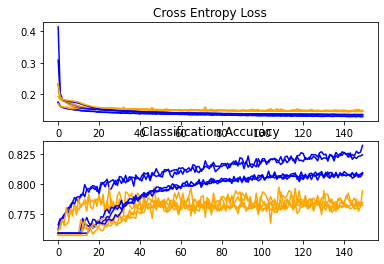

Accuracy: mean=80.851 std=1.727, n=5


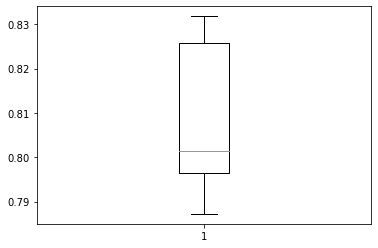

In [180]:
from sklearn.model_selection import KFold

def define_model():
    layer0 = Input(shape=tr.shape[1:], name='input')
    layer1 = Conv1D(filters=16, kernel_size=4, strides=1, kernel_initializer='glorot_normal',activation='relu',name='Conv1D_1')(layer0)
    layer2 = BatchNormalization()(layer1)
    layer3 = MaxPool1D(pool_size=1, strides=1)(layer2)

    layer4 = Conv1D(filters=12, kernel_size=4, strides=1, kernel_initializer='glorot_normal',activation='relu', name='Conv1D_2')(layer3)
    layer5 = MaxPool1D(pool_size=2, strides=2)(layer4)
    layer6 = GlobalAveragePooling1D()(layer5)


    layer7 = Flatten(name='Flatten_1')(layer6)
    layer8 = Dense(12,activation='relu',name='Dense_1')(layer7)
    layer9 = Dropout(0.00099,name='dropout_3')(layer8)
    layer10 = Dense(1,activation='relu',name='Dense_3')(layer9)
    layer11 = Dropout(0.00099,name='dropout_4')(layer10)

    ### Contextual regression
    layer12 = Dense(166*4,kernel_regularizer=tf.keras.regularizers.l1(0.0001),name='Contextual_Weight')(layer11) ## make first layer
    layer13 = Dropout(0.00099,name='dropout_5')(layer12)

    #### Dot Product
    layer14 = Flatten(name='Flatten_2')(layer0)
    layer15 = Multiply()([layer13,layer14]) ## same number of nodes as input feaures

#    layer16 = Dense(1, activation='sigmoid', kernel_initializer='ones',use_bias=False,name='Sum')(layer15)
    layer17 = Dense(1, activation='sigmoid', name='Output')(layer16)

    model = Model(inputs=layer0, outputs=layer17)
    #model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    model.compile(SGD(lr=0.01, momentum=0.9),'mean_squared_error', metrics=['accuracy']) ##, momentum=0.9

    return model


# evaluate a model using k-fold cross-validation
def evaluate_model(dataX=x_train2, dataY=y_train2, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
    # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        earlystop_cb = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')
        check_cb = ModelCheckpoint('bestparams2.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        history = model.fit(x_train2, y_train2, batch_size=16, epochs=150, validation_split=0.20, callbacks=[check_cb]) 
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # append scores
        scores.append(acc)
        histories.append(history)
    return scores, histories
 
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    for i in range(len(histories)):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(histories[i].history['loss'], color='blue', label='train')
    pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
    pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    pyplot.show()
    
    
    # summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    pyplot.boxplot(scores)
    pyplot.show()
    
    # run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    trainX=x_train2
    trainY=y_train2
    testX=x_test2
    testY=y_test2 
    # prepare pixel data
#    trainX, testX = prep_pixels(trainX, testX)
    # evaluate model
    scores, histories = evaluate_model(trainX, trainY)
    # learning curves
    summarize_diagnostics(histories)
    # summarize estimated performance
    summarize_performance(scores)
    
    # entry point, run the test harness
run_test_harness()